In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import gcm_filters
from intake import open_catalog

In [2]:
#loading data
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
list(cat)
ds = cat['CESM_POP_hires_RCP8_5'].to_dask()
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 16401, z_t: 62, z_w: 62,
                         z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/59)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    SHF_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  3535200
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2016-05-17 at 03:29:14.8
    tavg_sum:      86399.99999999999
    title:         BRCP85C5CN_ne120_t12_pop62.c13b17.asdphys.001

In [3]:
#See the fields needed to apply the filter:
gcm_filters.required_grid_vars(gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

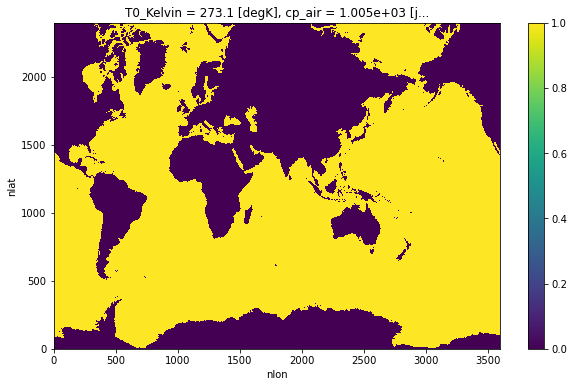

In [4]:
# create fields needed to apply the filter: wet mask and area
wet_mask = xr.where(ds['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

area = ds.TAREA / 10000  # convert units from cm2 to m2

In [5]:
#idk what chunk is...
wet_mask = wet_mask.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk
area = area.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk

ssh = ds.SSH_2.where(wet_mask)
ssh = ssh.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk


In [6]:
#filter specifications
specs = {
    'filter_scale': 30,
    'dx_min': 1,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
    'grid_type': gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED
}

In [7]:
#create the filter
filter_cpu = gcm_filters.Filter(grid_vars={'area': area, 'wet_mask': wet_mask}, **specs)
filter_cpu


Filter(filter_scale=30, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=33, grid_type=<GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>)

In [8]:
#Apply the filter
ssh_filtered = filter_cpu.apply(ssh, dims=['nlat', 'nlon'])

In [9]:
#Calculating the difference SSH - filtered SSH
ssh_SmallScale = ssh - ssh_filtered

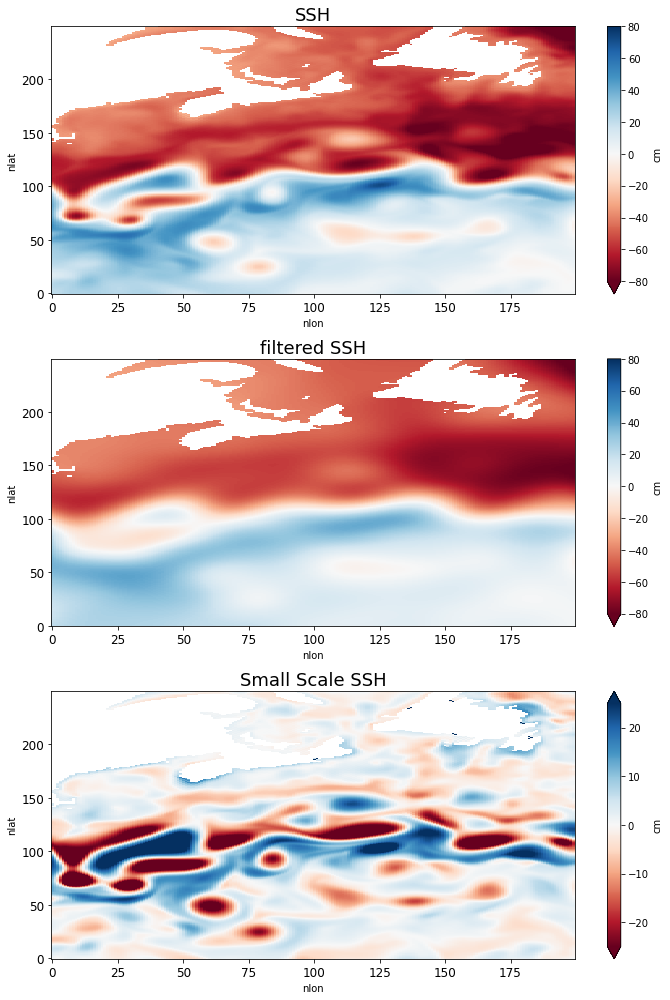

In [13]:
#plotting
vmin = -80
vmax = 80

vmin2 = -25
vmax2 = 25

yslice = slice(1500, 1750)
xslice = slice(400, 600)

fig,axs = plt.subplots(3,1,figsize=(10,14))
ssh.isel(nlat=yslice, nlon=xslice, time=1).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, cmap='RdBu',
    cbar_kwargs={'label': 'cm'}
)
axs[0].set_title('SSH', fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=12)

ssh_filtered.isel(nlat=yslice, nlon=xslice, time=1).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, cmap='RdBu',
    cbar_kwargs={'label': 'cm'}
)
axs[1].set_title('filtered SSH', fontsize=18);
axs[1].tick_params(axis='both', which='major', labelsize=12)

ssh_SmallScale.isel(nlat=yslice, nlon=xslice, time=1).plot(
    ax=axs[2], 
    vmin=vmin2, vmax=vmax2, cmap='RdBu',
    cbar_kwargs={'label': 'cm'}
)
axs[2].set_title('Small Scale SSH', fontsize=18);
axs[2].tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()

plt.savefig("filtered_SSH_test.png")